In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.vae import VAE
from networks.lossfunctions import *

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
data_folder = 'data/demoplanner/version1'
train_data = NumpyCsvDataSet(data_folder + '/train.csv')
test_data = NumpyCsvDataSet(data_folder + '/test.csv')
training_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=True)

In [5]:
print (train_data.data.shape)
print (test_data.data.shape)

torch.Size([13280, 2058])
torch.Size([1341, 2058])


In [14]:
%reset -f ComposedAutoEncoder
%reset -f VAE
from networks.composedautoencoder import ComposedAutoEncoder
from networks.vae import VAE

Don't know how to reset  composedautoencoder, please run `%reset?` for details
Don't know how to reset  vae, please run `%reset?` for details


In [15]:
expts = [
#     ['DemoPl-V1-ComposedAutoEncoder-MSE-', ComposedAutoEncoder, demopl_v1_data_adapter, mse_loss_adapter, demopl_v1_data_to_img],
    ['DemoPl-V1-VAE-VAELoss-', VAE, demopl_v1_data_adapter, vae_loss_adapter, demopl_v1_data_to_img],
]

Log folder for expt 0: runs/DemoPl-V1-VAE-VAELoss-03-10-21-53-09


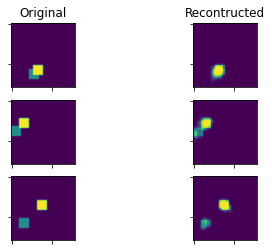

In [18]:
train_epochs = 200
for i in range(len(expts)):
    inputs = expts[i]
    runner = ExptRunner(inputs[0], inputs[1](), inputs[2], inputs[3])
    print ("Log folder for expt {}: {}".format(i, runner.log_folder))
    runner.train(train_epochs, training_loader)
    runner.test(test_loader, inputs[4])

In [ ]:
np.set_printoptions(**opt)